In [1]:
import datetime
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
import shutil
import requests
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/My Drive/airbnb/67400.csv')


In [3]:
# def get_brightness(data):
#     # opens image in current working directory, converts to greyscale, and pulls a float value for brightness
#     from PIL import Image, ImageStat
#     img_src = Image.open('img.png').convert('L')
#     img_src.save("img_greyscale.png") # saving this image to show comparison
#     stat = ImageStat.Stat(img_src)
#     brightness = stat.mean[0]
#     return brightness

In [4]:
# def get_img_from_url(data):
#     import math
#     bright_list = {'brightness': []}
#     for i in range(len(data)):
#         print(i)
#         try:
#           if str(data['thumbnail_url'][i]) == 'nan':
#               data['brightness'] = 0
#               bright_list['brightness'].append(0)
#               continue
#           response = requests.get(data['thumbnail_url'][i], stream=True)
#           with open('img.png', 'wb') as out_file:
#               shutil.copyfileobj(response.raw, out_file)
#           del response
#           brightness = get_brightness(data)
#           bright_list['brightness'].append(brightness)

#           if i % 100 == 0:
#             print("len", len(bright_list['brightness']), "i", i)
#             df = pd.DataFrame(bright_list)
#             df.to_csv('/content/drive/My Drive/airbnb/train_new_from_67400_new.csv')
#         except:
#           bright_list['brightness'].append(0)
            
#     return bright_list



In [5]:

# bright_list = get_img_from_url(data)
# df = pd.DataFrame(bright_list)
# df.to_csv('/content/drive/My Drive/airbnb/train_new_from_67400_new.csv')



In [6]:
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO

import keras

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import SGD


# view one of the images
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt



# # mix the data
# # def get_img(data):
# Airbnb_data = pd.read_csv('/content/drive/My Drive/airbnb/listings.csv')
# IMAGE_SIZE = [224,224]

# response = requests.get(Airbnb_data['picture_url'][4])
# img = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
# plt.imshow(img)
# # Airbnb_data.loc[:, 'price'] = np.exp(Airbnb_data['log_price'])
# Airbnb_data['price'] = Airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
# Airbnb_data = Airbnb_data.sample(frac=1)


# # gets a list of the images as well as the prices
# def get_img():
#   img_list = []
#   price_list = []
#   data_dict=()
#   for i in range(500):#len(Airbnb_data['price'])):
#     try:
#       if i % 100 == 0:
#         # gets 6,000 images
#         print(int((i/500)*100),'% done')#len(data['price']))*100)
#       response = requests.get(Airbnb_data['picture_url'][i])
#       img = Image.open(BytesIO(response.content)).resize([224,224])
#       # for i in range(len(X)):
#       #   if img.size != (224,224,3):
#       #     print(i)
#       # print(img.size)

#       img = np.array(img) / 255.0 # makes imputs [0,1]
#       if img.shape == (224,224,3):
#         img_list.append(img)
#       price_list.append(Airbnb_data.price[i])
#     except (KeyError or OSError):
#       pass
#   return img_list, price_list


In [7]:
Airbnb_data = pd.read_csv('../dataset/listings.csv')
Airbnb_data['price'] = Airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
Airbnb_data = Airbnb_data.sample(frac=1)
# remove all listings where the price is less then 500
Airbnb_data = Airbnb_data[Airbnb_data.price < 500]
# how many listings have a price of zero
len(Airbnb_data.loc[Airbnb_data['price'] == 0])
# if the price is less then 10 revome the listing
Airbnb_data = Airbnb_data[Airbnb_data.price > 10]

d:\users\liels\onedrive\desktop\airbnbprice\venv\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# gets a list of the images as well as the prices
def get_img():
  img_list = []
  price_list = []
  data_dict=()
  for i in range(502):#len(Airbnb_data['price'])):
    try:
      if i % 100 == 0:
        # gets 6,000 images
        print(int((i/500)*100),'% done')#len(data['price']))*100)
      response = requests.get(Airbnb_data['picture_url'][i])
      img = Image.open(BytesIO(response.content)).resize([224,224])

      img = np.array(img) / 255.0 # makes imputs [0,1]
      if img.shape == (224,224,3):
        img_list.append(img)
      # img_list.append(img)
        price_list.append(Airbnb_data.price[i])
    except (KeyError or OSError):
      pass
  return img_list, price_list

In [9]:
X, y = get_img()
len(X)
# len(test_y)


0 % done
20 % done
40 % done
60 % done
80 % done
100 % done


486

In [10]:
# split up the training set and test set
train_X = np.asarray(X[:350])
train_y = np.array(y[:350])
test_X = np.asarray(X[350:])
test_y = np.array(y[350:])
len(test_y)

136

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

# train the model on the new data for a few epochs
model.fit(train_X[:200],train_y[:200],steps_per_epoch=10, epochs=3,validation_split = 0.2,validation_steps=10)

Epoch 1/3
10/10 [==============================] - 13s 931ms/step - loss: 7740.7593 - mse: 7740.7593 - mae: 65.2500 - val_loss: 7862.5127 - val_mse: 7862.5127 - val_mae: 60.0201

In [12]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))

5/5 [==============================] - 7s 995ms/step
105.53753654169864


In [13]:
# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# # from keras.optimizers import SGD
# model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# model.fit(train_X[:200],train_y[:200],steps_per_epoch=10, epochs=3,validation_split = 0.2,validation_steps=10)

In [14]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))

5/5 [==============================] - 5s 998ms/step
105.53753654169864


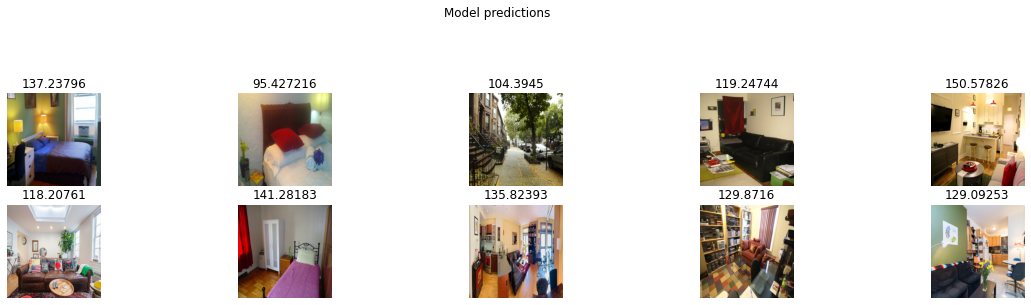

In [15]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(pred[n][0])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

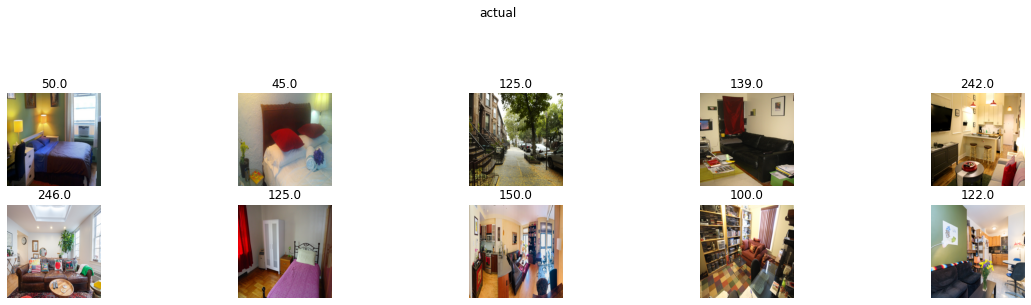

In [16]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(test_y[n])
  plt.axis('off')
_ = plt.suptitle("actual")

In [17]:
model.save("../dataset/image_model_500")
model.save("../dataset/image_model_500.h5")



INFO:tensorflow:Assets written to: ../dataset/image_model_500\assets


INFO:tensorflow:Assets written to: ../dataset/image_model_500\assets


In [18]:
def get_img_from_url(data):
    import math
    price_by_model_list = {'price_by_model': []}
    for i in range(len(data)):
        try:
          pred = []
          if str(data['thumbnail_url'][i]) == 'nan':
            # data['price_by_model'] = 0
            price_by_model_list['price_by_model'].append(0)
            continue
          response = requests.get(data['thumbnail_url'][i])
          img = Image.open(BytesIO(response.content)).resize([224,224])
          img = np.array(img) / 255.0 # makes imputs [0,1]
          perd = model.predict(np.asarray([img]))[0][0]
          price_by_model_list['price_by_model'].append(perd)
          if i % 100 == 0:
            print(i, perd)
            print("len", len(price_by_model_list['price_by_model']), "i", i)
            df = pd.DataFrame(price_by_model_list)
            df.to_csv('../dataset/price_by_model.csv')
        except:
          price_by_model_list['price_by_model'].append(0)
            
    return price_by_model_list


In [19]:
data = pd.read_csv('../dataset/train.csv')
price_by_model_list = get_img_from_url(data[60000:])
df = pd.DataFrame(price_by_model_list)
df.to_csv('../dataset/price_by_model.csv')

In [20]:
# response = requests.get(Airbnb_data['picture_url'][5])
# img = Image.open(BytesIO(response.content)).resize([224,224])
# img = np.array(img) / 255.0 # makes imputs [0,1]
# # price_by_model['price_my_model'] = model.predict(np.asarray(img))
# print(model.predict(np.asarray([img])))